In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=14)

In [2]:
tag = 'saved/2020-05-19T20:30:00.674442'
conf_name ='rank'
algorithms = ['charge', 'charge_tweaked', 'classic']

In [3]:
def get_rank_data(algorithms):
    # Paths to Benchmark Results
    result_dir = Path('./results')
    rank_dir = result_dir.joinpath(tag, conf_name)
    
    data = {}
    for alg in algorithms:
        path = rank_dir.joinpath(f'{alg}.csv')
        data[alg] = pd.read_csv(path,dtype={'start_node': str, 'target_node': str})
    
    if 'classic' in algorithms:
        ranks = data['classic']['dijkstra_rank']
        for alg in algorithms:
            data[alg]['rank'] = ranks
        
    return data

data = get_rank_data(algorithms + ['insert'])

## Ranked Stats

In [4]:
data['insert'].head()

start_node target_node  charging_stations  time_insert_start  \
0   265817182   258854554                 40           7.724615   
1  3361020327   613537039                 40           7.184708   
2   660867374   410183835                 40           9.312661   
3    30923261   373456785                 40           9.361831   
4   363942287  3863369611                 40           9.949534   

   time_insert_target  time_contracted_graph  time_state_graph  run_id  rank  
0            8.010607             136.238119          0.147983       0    64  
1            7.931797             136.238119          0.147983       0    64  
2            8.717097             136.238119          0.147983       0    64  
3            9.122940             136.238119          0.147983       0    64  
4           10.303849             136.238119          0.147983       0    64

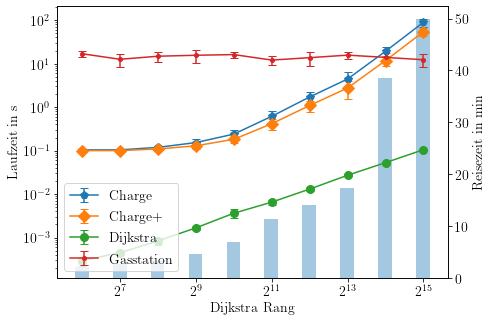

In [11]:
def plot_ranked_data(data):
    
    def rank_stats(k, y, label, marker):
        _means = data[k].groupby(['rank']).mean()
        _std = data[k].groupby(['rank']).std()
        _x = _means.index
        _y = _means[y]
        _yerr = _std[y]
        plt.errorbar(_x, _y, yerr=_yerr, fmt='-', marker=marker, markersize=8, label=label, capsize=4)
        #plt.plot(_x, _y, '-', marker=marker, markersize=8, label=label)
        plt.xticks(_x)
        
    
    setup = [
        ('astar', 's', 'A*'),
        ('charge', 'p', 'Charge'),
        ('charge_tweaked', 'D', 'Charge+'),
        ('classic', 'o', 'Dijkstra')
    ]
    
    fig, ax = plt.subplots(figsize=(7,5))
    
    for k, marker, name in setup:
        if k not in algorithms:
            continue
        rank_stats(k, 'query_time', name, marker)

    if 'insert' in data:
        _means = data['insert'].groupby(['rank']).mean()
        _std = data['insert'].groupby(['rank']).std()
        _x = _means.index
        _y = _means['time_insert_start'] + _means['time_insert_target'] #+ _means['time_contracted_graph']
        _yerr = _std['time_insert_start'] + _std['time_insert_target']
        plt.errorbar(_x, _y, yerr=_yerr, fmt='-', marker='.', markersize=8, label='Gasstation', capsize=4)
        

    ax.set_yscale('log')
    ax.set_xscale('log', basex=2)
    ax.set_xlabel(r'Dijkstra Rang')
    ax.set_ylabel(r'Laufzeit in s')
    plt.legend(loc='lower left')

    # Travel times
    ax2 = ax.twinx()
    means = data['charge'].groupby(['rank']).mean()
    widths = np.zeros(len(means) + 1)
    widths[1:] = means.index.values
    widths[0] = widths[1] / 2
    widths = (widths[1:] - widths[:-1]) / 2
    ax2.bar(means.index, means['trip_time']/60, width=widths, alpha=.4)
    ax2.set_ylabel('Reisezeit in min')
    
    # Plot bar plot in the background
    ax.set_zorder(1)
    ax.patch.set_visible(False)
    ax2.set_zorder(0)
    
    plt.savefig('img/ranks.pdf', bbox='tight')
        
plot_ranked_data(data)